# Prep

This blocks installs all the neccesary dependancies, and imports the relevant files

* import tf.models
* install relevant packages 
* import standard dataset
* import additional dataset
* define helper functions


In [1]:
!pip -q install tf_slim
!pip -q install pycocotools
!pip install -q -U tensorflow-addons

     |████████████████████████████████| 358kB 2.6MB/s 
     |████████████████████████████████| 1.1MB 2.7MB/s 


In [2]:
# Import tensorflow.models into the current directory
import os 
import pathlib
import sys

from tqdm.notebook import tqdm

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('...')
elif not pathlib.Path('models').exists():
  print('Downloading from github ... ')
  !git clone --depth 1 https://github.com/tensorflow/models

os.environ['PYTHONPATH'] += ":/content/models"
sys.path.append("/content/models")

Cloning into 'models'...
remote: Enumerating objects: 2191, done.
remote: Counting objects: 100% (2191/2191), done.
remote: Compressing objects: 100% (1895/1895), done.
remote: Total 2191 (delta 526), reused 932 (delta 270), pack-reused 0
Receiving objects: 100% (2191/2191), 30.41 MiB | 13.30 MiB/s, done.
Resolving deltas: 100% (526/526), done.


In [3]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [4]:
%%bash 
cd models/research
pip -q install .

In [5]:
# Download data from drive into cwd

if 'Data' not in os.listdir():
  !cp "/content/drive/My Drive/ML/waste_detection/Data/med_res_2.zip" .
  !unzip -q med_res_2.zip -d Data
  # Remove the zip file 
  !rm med_res_2.zip

In [6]:
# folder_names = ['extra_furnitures',
#                 'extra_mattresses',
#                 'extra_various',
#                 'extra_WEEE',
#                 'extra_tyres',
#                 'extra_cylinders']

# for folder_name in tqdm(folder_names):
#   if folder_name not in os.listdir():

#     zipfile = folder_name + '.zip'
#     path = "/content/drive/My Drive/ML/waste_detection/Data/" + zipfile
    
#     !cp '$path' .
#     !unzip -q '$zipfile' -d '$folder_name'
#     !rm '$zipfile'

In [7]:
import matplotlib
import matplotlib.pyplot as plt

import os
import shutil
import json
import random
import re
import io
import imageio
import cv2
import glob
import scipy.misc
import math
import numpy as np
import tensorflow_addons as tfa
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline


In [8]:
# Helper functions 
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Load images into numpy arrays 
def image_to_np(dir, w, h):
  output = [None] * len(os.listdir(dir))
  i = 0
  for file in tqdm(os.listdir(dir)):
    img = load_image_into_numpy_array(dir + file)
    res = cv2.resize(img, dsize=(w, h), interpolation=cv2.INTER_CUBIC)
    output[i] = res
    i += 1
  return output

# Utilizes the visualization_utils
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None,
                    threshold = 0.8):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=threshold)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)
  
def split_data(SOURCE, TRAIN_DIR, TEST_DIR, SPLIT_PERCENT, seed = False, FILENAMES=None):

  # Get a list of image names

  if FILENAMES == None:
    files = []
    for filename in os.listdir(SOURCE):
        filepath = SOURCE + filename
        if filepath.endswith('.jpg'):
            files.append(filename)
  else:
    files = FILENAMES

  # Define test and train length
  train_length = int(len(files) * SPLIT_PERCENT)
  test_length = int(len(files)-train_length)

  # Shuffle and split
  if not seed:
    random.seed(1)
    random.shuffle(files)
    training_set = files[0:train_length]
    testing_set = files[-test_length:]
  else:
    training_set = []
    testing_set = []
    for filename in files:
      if filename in seed:
        testing_set.append(filename)
      elif filename not in seed:
        training_set.append(filename)

  # move the files
  for filename in training_set:
      os.replace(SOURCE+filename, TRAIN_DIR + filename)
      # shutil.copyfile(SOURCE+filename, TRAIN_DIR+filename)
  for filename in testing_set:
      os.replace(SOURCE+filename, TEST_DIR + filename)
      # shutil.copyfile(SOURCE+filename, TEST_DIR+filename)


# Move
This block moves the images in place and stores the data in memory

* split images into train and test folders
* all json files are stored in the same folder
* normalize boxes
* store all images as numpy arrays into memory
* convert np arrays into tensors, to be passed into model

In [9]:
# Split data into train and test folders

def extract(label, category):
  if label[category] is not None:
    return np.array(label[category])

current_dir = os.getcwd()
image_path = os.path.join(current_dir, 'Data/images')
label_path = os.path.join(current_dir, 'Data/bboxes')

label_names = {1: 'black_bag_waste'}

category_index = {}
for i in label_names:
  category_index[i] = {'id': i, 'name': label_names[i]}

# Note: fire_extinguishers will be combined with gas_bottles_or_cylinders

valid_jpgs = []

# Select only samples that contain classes from above:
for filepath in os.listdir(image_path):
  filename = filepath.split('/')[-1]
  if filename.endswith('.jpg'):
    json_file = os.path.join(label_path, filename[:-4]+'_bboxs.json')
    with open(json_file, 'r') as file:
      annotation = json.load(file)
      filtered_annotation = np.array([extract(annotation, label_names[i]) for i in label_names])
      for Class in filtered_annotation:
        # Only append if not empty
        if Class is not None:
          valid_jpgs.append(filename)
          break
        # print(annotation[Class])

print(len(os.listdir(image_path)))
print(len(valid_jpgs))

222
157


In [10]:
try: 
  os.mkdir(image_path + '/train')
  os.mkdir(image_path + '/test')
  print('Created train and test directories')
except:
  pass

train_dir = os.path.join(image_path, 'train/')
test_dir = os.path.join(image_path, 'test/')

test_images = []
with open('Data/test_set.txt') as seed:
  for line in seed:
    test_images.append(line.split('\n')[0])

# Execute moving files
try:
  split_data(image_path+'/', train_dir, test_dir, 0.9, seed=test_images, FILENAMES = valid_jpgs)
except OSError:
  print('error raised')
  pass

print('train folder: {}, test folder: {}'.format(len(os.listdir(train_dir)), len(os.listdir(test_dir))))

Created train and test directories
train folder: 139, test folder: 18


In [11]:
# count = 0
# for extra_path in folder_names:
#   extra_path += '/'
#   extra_image_path = extra_path + 'images/'
#   extra_bbox_path = extra_path + 'bboxes/'
#   for filepath in os.listdir(extra_image_path):
#     filename = filepath.split('/')[-1]
#     # print(filename)
#     if filename.endswith('.jpg'):
#       annotation_file = filename[:-4] + '_bboxs.json'
#       if annotation_file in os.listdir(extra_bbox_path):
#         with open(extra_bbox_path+annotation_file, 'r') as file:
#           annotation = json.load(file)
#           filtered_annotation = np.array([extract(annotation, label_names[i]) for i in label_names])
#           for Class in filtered_annotation:
#             # Only append if not empty
#             if Class is not None:
#               count += 1
#               os.replace(extra_image_path+filename, 'Data/images/train/' + filename)
#               os.replace(extra_bbox_path+annotation_file, 'Data/bboxes/' + annotation_file)
#               break
#         # print(annotation_file)

# print('Added {} images'.format(count))
# print('train folder: {}, test folder: {}'.format(len(os.listdir(train_dir)), len(os.listdir(test_dir))))

In [12]:
# Load label json files into numpy arrays 

def json_to_np(dir):
  output_boxes = []
  output_classes = []
  for i, file in enumerate(os.listdir(dir)):
  #     # Get name of the file
      label_file = os.path.join(label_path, file[:-4]+'_bboxs.json')
      with open(label_file, 'r') as file:
        label = json.load(file)

      categories = np.array([extract(label, label_names[i]) for i in label_names])

      boxes = np.array([[0, 0, 0, 0]])
      classes = np.array([])

      for index, category in enumerate(categories):
        if category is not None:
          boxes = np.vstack([boxes, category])
          classes = np.append(classes, np.array([int(index+1)]*len(category)))
    
      output_boxes.append(boxes[1:].astype('float'))
      output_classes.append(classes.astype('int32'))

  return output_boxes, output_classes

difficult_label_dir = 'Data/bboxes_d/'

def json_to_np_d(dir):
  
  output_difficults = []
  for i, file in enumerate(os.listdir(dir)):
  #     # Get name of the file
      label_file = os.path.join(difficult_label_dir, file[:-4]+'_bboxs_d.json')
      with open(label_file, 'r') as file:
        label = json.load(file)

      filtered_annotation = np.array([extract(label, label_names[i]) for i in label_names])

      difficults = np.array([])

      for index, category in enumerate(filtered_annotation):
        if category is not None:
          for box in category:
            difficults = np.append(difficults, box[1])

      output_difficults.append(difficults.astype('int32'))

  return output_difficults

y_train_boxes, y_train_classes = json_to_np(train_dir)
y_test_boxes, y_test_classes = json_to_np(test_dir)
y_test_difficults = json_to_np_d(test_dir)

In [13]:
# Normalize the labels 

# width: 420, height: 312
# Data format right now: [xmin, ymin, xmax, ymax]
# Target format         : [ymin, xmin, ymax, xmax]

orig_width = 640
orig_height = 640

target_width = orig_width
target_height = orig_height

def normalize_boxes(labels):
  for label in labels:
    for box in label:
      box[0], box[1], box[2], box[3] = box[1], box[0], box[3], box[2]
  return labels

y_train_boxes = normalize_boxes(y_train_boxes)
y_test_boxes = normalize_boxes(y_test_boxes)

print(y_test_boxes[1])

[[0.14102564 0.51456311 0.20192308 0.57281553]
 [0.12179487 0.62378641 0.18108974 0.70145631]
 [0.16987179 0.35679612 0.26121795 0.44174757]
 [0.42788462 0.21116505 0.64262821 0.33980583]
 [0.36698718 0.12135922 0.42307692 0.18203883]]


In [14]:
# Merge Classes + distribution Summary

distribution_train = {}
distribution_test = {}
distribution_test_trivial = {}

for i in label_names:
  distribution_train[label_names[i]] = 0
  distribution_test[label_names[i]] = 0
  distribution_test_trivial[label_names[i]] = 0

for annotation in y_train_classes:
  for j, Class in enumerate(annotation):
    if Class == 5:
      annotation[j] = 2
    distribution_train[label_names[annotation[j]]] += 1

for annotation in y_test_classes:
  for j, Class in enumerate(annotation):
    if Class == 5:
      annotation[j] = 2
    distribution_test[label_names[annotation[j]]] += 1

print('Train Set')
print(distribution_train)
print('\nTest set')
print(distribution_test)

Train Set
{'black_bag_waste': 480}

Test set
{'black_bag_waste': 132}


In [15]:
# Filtering to trivial boxes only:

temp_difficults_test = []
for i, sample in enumerate(y_test_difficults):
  temp_index = []
  for j, diff in enumerate(sample):
    if diff == 1:
      temp_index.append(j)
  temp_difficults_test.append(temp_index)

# temp_difficults[1]

y_test_boxes_trivial = []
y_test_classes_trivial = []

for i, temp_difficult in enumerate(temp_difficults_test):
  y_test_boxes_trivial.append(np.delete(y_test_boxes[i], temp_difficult, 0))
  y_test_classes_trivial.append(np.delete(y_test_classes[i], temp_difficult, 0))

for annotation in y_test_classes_trivial:
  for j, Class in enumerate(annotation):
    if Class == 5:
      annotation[j] = 2
    distribution_test_trivial[label_names[annotation[j]]] += 1

print('Test Set')
print(distribution_test)
print('\nTest set (Trivial annotations only)')
print(distribution_test_trivial)

Test Set
{'black_bag_waste': 132}

Test set (Trivial annotations only)
{'black_bag_waste': 98}


In [16]:
x_train_np = image_to_np(train_dir, target_width, target_height)
print(f'\n Appended and resized {len(x_train_np)} training images')

x_test_np = image_to_np(test_dir, target_width, target_height)
print(f'\n Appended and resized {len(x_test_np)} training images')




 Appended and resized 139 training images




 Appended and resized 18 training images


## np_to_tensors()




In [17]:
# Prepping data, converting np arrays into tensors 

num_classes = 1

def np_to_tensors(image_nps, box_nps, class_nps):
  label_id_offset = 1

  image_tensors = []
  box_tensors = []
  classes_one_hot_tensors = []

  for (image_np, box_np, class_np) in zip(image_nps, box_nps, class_nps):
    image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
        image_np, dtype=tf.float32), axis=0))
    
    box_tensors.append(tf.convert_to_tensor(box_np, dtype=tf.float32))
    
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(class_np - label_id_offset, dtype=np.int32)
    classes_one_hot_tensors.append(tf.one_hot(
        zero_indexed_groundtruth_classes, num_classes))

  return image_tensors, box_tensors, classes_one_hot_tensors

train_image_tensors, gt_box_tensors, gt_classes_one_hot_tensors = np_to_tensors(x_train_np, y_train_boxes, y_train_classes)
test_image_tensors, test_gt_box_tensors, test_gt_classes_one_hot_tensors = np_to_tensors(x_test_np, y_test_boxes, y_test_classes)

# print('Done prepping data.')

In [ ]:
# # Optional: visulize images

# plt.rcParams['axes.grid'] = False
# plt.rcParams['xtick.labelsize'] = False
# plt.rcParams['ytick.labelsize'] = False
# plt.rcParams['xtick.top'] = False
# plt.rcParams['xtick.bottom'] = False
# plt.rcParams['ytick.left'] = False
# plt.rcParams['ytick.right'] = False
# plt.rcParams['figure.figsize'] = [14, 7]

# plt.figure(figsize=(30, 15))
# for i in range(6):
#   offset = 36
#   plt.subplot(2, 3, i+1)
#   plot_detections(
#       cv2.resize(x_train_np[i+ offset], dsize=(421, 320), interpolation=cv2.INTER_CUBIC),
#       y_train_boxes[i+ offset],
#       y_train_classes[i+ offset],
#       np.ones(shape=[y_train_boxes[i+ offset].shape[0]], dtype=np.float16),
#       category_index)
# plt.axis('off')

# plt.show()



# Load Config

This block creates the model metaArch, and loads untrained weights

* download weights from tensorflow.models
* loads the config file from '/models/research/object_detection/configs'
* restores weights and create a checkpoint instance



In [18]:
if 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8' not in os.listdir():
  !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz 
  !tar -xf ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
  !rm ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz

--2020-09-22 13:19:45--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.203.128, 2404:6800:4008:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.203.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20518283 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.57M  24.5MB/s    in 0.8s    

2020-09-22 13:19:47 (24.5 MB/s) - ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’ saved [20518283/20518283]



In [19]:
# Configuring and creating the detection model (weight's are not loaded here)

num_classes = 1

pipeline_config = 'models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.config'
checkpoint_path = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt'

raw_checkpoint = checkpoint_path + '-0'


# Load pipeline config and build a detection model architecture (only need to be ran once)

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
    model_config = model_config, is_training=True
)


In [20]:
# Restore weights (original weights)

def restore_weights(ckpt_path, restore_all=True):

  print(f'restoring weights from {str(ckpt_path)}')

  if restore_all:
    ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
    ckpt.restore(ckpt_path).expect_partial()
  
  else:
    fake_box_predictor = tf.compat.v2.train.Checkpoint(
      _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
      _box_prediction_head=detection_model._box_predictor._box_prediction_head
      )

    fake_model = tf.compat.v2.train.Checkpoint(
                _feature_extractor=detection_model._feature_extractor,
                _box_predictor=fake_box_predictor)
  
    ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
    ckpt.restore(ckpt_path).expect_partial()

  # Run model through a dummy image so that variables are created
  image, shapes = detection_model.preprocess(tf.zeros([1, target_height, target_width, 3]))
  prediction_dict = detection_model.predict(image, shapes)
  _ = detection_model.postprocess(prediction_dict, shapes)
  print('Weights restored!')

  return ckpt

# Initialize ckpt
ckpt = restore_weights(raw_checkpoint, restore_all=False)

restoring weights from ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-0
Weights restored!


# Functions
This block contains the following functions:

* step function (for both training and evaluating)
* layer extraction function
* main training block (given hyperparameters)

### get_model_train_step_function()


In [21]:
# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list,
                    backprop = True):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(len(image_tensors) * [[target_height, target_width, 3]], dtype=tf.int32)

    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)

    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)

      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']

      if backprop:
        gradients = tape.gradient(total_loss, vars_to_fine_tune)
        optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))

    return total_loss, detection_model.postprocess(prediction_dict, shapes)

  return train_step_fn

### get_variables()


In [22]:
def get_variables(prefixes_to_train):
  trainable_variables = detection_model.trainable_variables
  to_fine_tune = []
  for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
      to_fine_tune.append(var)
  return to_fine_tune

### train()

In [23]:
def train(epochs, 
          batch_size, 
          train_step_fn, 
          flip_prob = 0.2,
          rotate_prob = 0.2,
          hue_prob = 0.2, 
          crop_prob = 0.2):
  '''
    Performs training given epoch and batch size 

    Note: this function does not generalize, neither x_train_np or labels are passed
    as arguments
  '''

  tf.keras.backend.clear_session()

  num_batches = (len(x_train_np) // batch_size) + 1

  print('Started fine-tuning!', flush=True)

  cv_loss, cv_map = test_evaluate()

  print(f'Initial cv_loss: {cv_loss:.6f}, cv_map: {cv_map:.6f}')

  for e in range(epochs):

    epoch_loss = 0

    all_keys = list(range(len(x_train_np)))
    random.shuffle(all_keys)

    for i in tqdm(range(num_batches)):

      image_list, boxes_list, classes_list = [], [], []

      # Grab keys for a random subset of examples
      example_keys = all_keys[(i*batch_size):((i+1)*batch_size)]

      for key in example_keys:
        temp_image = x_train_np[key]
        temp_box = y_train_boxes[key]
        temp_class = y_train_classes[key]
        
        # Augmentation:
        temp_image, temp_box = random_horizontal_flip(temp_image, temp_box, flip_prob)
        temp_image, temp_box = random_rotate(temp_image, temp_box, rotate_prob)
        temp_image, temp_box = random_hue(temp_image, temp_box, hue_prob)
        temp_image, temp_box, temp_class = random_crop(temp_image, temp_box, temp_class, crop_prob)

        image_list.append(temp_image)
        boxes_list.append(temp_box)
        classes_list.append(temp_class)

      image_tensors, boxes_tensors, classes_tensors = np_to_tensors(image_list, boxes_list, classes_list)

      # Training step (forward pass + backwards pass)
      total_loss, _ = train_step_fn(image_tensors, boxes_tensors, classes_tensors)

      epoch_loss += total_loss.numpy()

    epoch_loss /= num_batches

    cv_loss, cv_map = test_evaluate()
    print('epoch {} of {}, loss= {:.6}, cv_loss = {:.6}, cv_map = {:.6}'.format(e+1, epochs, epoch_loss, cv_loss, cv_map))

  print(f'final cv_loss: {cv_loss :.6}, cv_map: {cv_map :.6}')
  print('Done fine-tuning!')

### test_evaluate()

In [24]:
def test_evaluate():
  batch_size = 5
  loss = 0
  num_batches = len(test_image_tensors) // batch_size + 1
  # train_step_fn(test_image_tensors, test_gt_box_tensors, test_gt_classes_one_hot_tensors, backprop=False)

  keys = list(range(len(x_test_np)))

  detected_boxes = []
  detected_classes = []
  detected_scores = []

  for i in range(num_batches):
    key_batch = keys[(i*batch_size):((i+1)*batch_size)]
    gt_boxes_list, gt_classes_list, image_tensors = [], [], []

    for key in key_batch:
      image_tensors.append(test_image_tensors[key])
      gt_boxes_list.append(test_gt_box_tensors[key])
      gt_classes_list.append(test_gt_classes_one_hot_tensors[key])

    batch_loss, detections = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list, backprop=False)

    for score, Class, box in zip(detections['detection_scores'], detections['detection_classes'], detections['detection_boxes']):
      detected_score, detected_class, detected_box = filter_from_score(score.numpy(),
                                                                      Class.numpy()+1,
                                                                      box.numpy(),
                                                                      threshold = 0.1)
      detected_boxes.append(detected_box)
      detected_classes.append(detected_class)
      detected_scores.append(detected_score)  

    loss += batch_loss

  _, _, maps = calculate_map(detected_boxes, 
                          detected_classes, 
                          detected_scores, 
                          y_test_boxes, 
                          y_test_classes, 
                          num_of_classes = num_classes,
                          iou_threshold = 0.5, 
                          suppress_output = True)
  
  map = sum(maps)/num_classes
  return loss.numpy()/num_batches, map

### random_hue()

In [25]:
def random_hue(image_np, boxes, probability):
  if random.random() < probability:
    image_np = tf.image.random_contrast(tf.image.random_hue(tf.image.random_brightness(image_np, 0.2), 0.1), 0.8, 1.2).numpy()
  return image_np, boxes

### random_horizontal_flip()

In [26]:
# Flip box
def flip_box_left_right(boxes):
  tempboxes = boxes.copy()
  for i in range(len(tempboxes)):
    tempboxes[i][1], tempboxes[i][3] = 1 - tempboxes[i][3], 1 - tempboxes[i][1]
    # tempboxes[i][3] = 1 - tempboxes[i][1]
  
  return tempboxes

def random_horizontal_flip(image_np, boxes, probability):
  if random.random() < probability:
    image_np = tf.image.flip_left_right(image_np).numpy()
    boxes = flip_box_left_right(boxes)
  return image_np, boxes

### random_rotate()

In [27]:
def two_points_to_four_points(box):
  coord_1 = (box[0], box[1])
  coord_2 = (box[2], box[1])
  coord_3 = (box[2], box[3])
  coord_4 = (box[0], box[3])
  return([coord_1, coord_2, coord_3, coord_4])

def rotate_coordinates(boxes, alpha):
  output_boxes = []
  for j, box in enumerate(boxes):
    box = two_points_to_four_points(box)
    for i, coord in enumerate(box):
      x_rel = coord[0] - 0.5
      y_rel = 0.5 - coord[1]
      if -1e-6 < x_rel < 1e-6:
        x_rel = 1e-6
      r = ((x_rel)**2 + (y_rel)**2)**0.5
      theta = math.atan(y_rel/x_rel)
      if theta < 0:
        if y_rel > 0:
          theta += math.pi
      if theta > 0:
        if y_rel < 0:
          theta += math.pi

      new_coord = (r * math.cos(theta+alpha) + 0.5, 0.5 - r*math.sin(theta+alpha))
      box[i] = new_coord
    output_boxes.append(box)

  return output_boxes

def rotate_box(boxes, alpha):
  boxes = rotate_coordinates(boxes, alpha)
  output_boxes = np.array([0, 0, 0, 0])
  for box in boxes:
    xmin = min(coord[0] for coord in box)
    ymin = min(coord[1] for coord in box)
    xmax = max(coord[0] for coord in box)
    ymax = max(coord[1] for coord in box)

    if xmin < 0: 
      xmin = 0
    if xmax > 1:
      xmax = 1
    if ymin < 0:
      ymin = 0
    if ymax > 1:
      ymax = 1

    output_boxes = np.vstack([output_boxes, [xmin, ymin, xmax, ymax]])
  
  return output_boxes[1:]

def random_rotate(image_np, boxes, probability):

  if random.random() < probability:
    alpha = random.random() * math.pi/8 - math.pi/16
    image_np = tfa.image.rotate(image_np, alpha).numpy()
    boxes = rotate_box(boxes, -alpha)

  return image_np, boxes


### random_crop()

In [28]:
# scaling: 

def random_crop(image_np, boxes, classes, probability):

  if random.random() < probability:
    width = image_np.shape[0]
    height = image_np.shape[1]

    crop_width = random.randint(math.floor(0.6 * width), math.floor(0.9*width))
    crop_height = random.randint(math.floor(0.6 * height), math.floor(0.9*height))

    offset_x = random.randint(0, width - crop_width)
    offset_y = random.randint(0, height - crop_height)

    image_np = tf.image.crop_to_bounding_box(image_np, offset_y, offset_x, crop_height, crop_width).numpy()

    temp_boxes = np.array([[0, 0, 0, 0]])
    temp_classes = np.array([]).astype('int')

    for box, Class in zip(boxes, classes):
      temp_box = np.array([0, 0, 0, 0]).astype('float16')

      area_before = ((box[3] - box[1]) * (box[2] - box[0])) * width * height

      temp_box[0], temp_box[2] = box[0] * height - offset_y, box[2] * height - offset_y
      temp_box[1], temp_box[3] = box[1] * width - offset_x, box[3] * width - offset_x

      temp_box[0], temp_box[2] = (temp_box[0]) / crop_height, (temp_box[2]) / crop_height
      temp_box[1], temp_box[3] = (temp_box[1]) / crop_width, (temp_box[3]) / crop_width

      if temp_box[0] < 0:
        temp_box[0] = 0
      if temp_box[1] < 0:
        temp_box[1] = 0
      if temp_box[2] > 1:
        temp_box[2] = 1
      if temp_box[3] > 1:
        temp_box[3] = 1

      area_after = ((temp_box[3] - temp_box[1]) * (temp_box[2] - temp_box[0])) * crop_width * crop_height
      
      if area_after > 0.5 * area_before:
        temp_boxes = np.vstack([temp_boxes, temp_box])
        temp_classes = np.append(temp_classes, Class)

      boxes = temp_boxes[1:]
      classes = temp_classes

  return image_np, boxes, classes


## mAP Block

In [29]:
# Calculate IOU 
  # There is one IOU value per box (in prediction)
  # Match to Ground truth or none

# Ground truth boxes: m x 4 np array 
# Detection boxes: 1 x 100 x 4 tensor 

# [ymin, xmin, ymax, xmax]

# xi1 = maximum of the x1 coordinates of the two boxes
# yi1 = maximum of the y1 coordinates of the two boxes
# xi2 = minimum of the x2 coordinates of the two boxes
# yi2 = minimum of the y2 coordinates of the two boxes

def iou(box1, box2):
  """Implement the intersection over union (IoU) between box1 and box2
    
  Arguments:
  box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
  """

  # Assign variable names to coordinates for clarity
  (box1_y1, box1_x1, box1_y2, box1_x2) = box1
  (box2_y1, box2_x1, box2_y2, box2_x2) = box2
  
  # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2
  xi1 = np.maximum(box1_x1, box2_x1)
  yi1 = np.maximum(box1_y1, box2_y1)
  xi2 = np.minimum(box1_x2, box2_x2)
  yi2 = np.minimum(box1_y2, box2_y2)
  inter_width = yi2 - yi1
  inter_height = xi2 - xi1
  if inter_width < 0 or inter_height < 0:
      return 0
  inter_area = inter_width * inter_height

  # Calculate the Union area
  box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
  box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
  union_area = (box1_area + box2_area) - inter_area
  
  # compute the IoU
  iou = inter_area / union_area
  
  return iou

def filter_from_score(scores, classes, boxes, threshold):
  for i, score in enumerate(scores):
    if score < threshold:
      break
  return scores[:i], classes[:i], boxes[:i]

def get_ious(detected_boxes, detected_classes, gt_boxes, gt_classes):

  '''
    Arguments:
    detected_boxes: (m x 4) for each image
    detected_classes: (m x 1) for each image

    gt_boxes: (n x 4)
    gt_classes: (n x 1)
  
    Output:
    iou_arr: (m x 4), maximum iou for each detection
    detected_which: (m x 4) index to detection
  '''

  ious_arr = [0] * len(detected_boxes)
  detected_which = [-1] * len(detected_boxes)
  hash_table = [None] * len(gt_boxes)

  # edge case: no detections or no ground truth boxes
  if len(detected_boxes) == 0:
    return [], []

  if len(gt_boxes) == 0:
    # print(f'no objects, {len(detected_boxes)} detections all wrong')
    return [0] * len(detected_boxes), [-1] * len(detected_boxes)

  for idx_detection, (box, label) in enumerate(zip(detected_boxes, detected_classes)):
    max_iou = 0
    # assume no detection
    for idx_gt, (gt_box, gt_class) in enumerate(zip(gt_boxes, gt_classes)):
      if gt_class == label:
        iou_val = iou(gt_box, box)
        if iou_val > max_iou:
          max_iou = iou_val
          detected_which[idx_detection] = idx_gt
    
    detected_gt = detected_which[idx_detection]
    if not hash_table[detected_gt]:
      # print(detected_gt)
      hash_table[detected_gt] = (max_iou, idx_detection)
    else:
      # compare iou, if larger than existing assigned value for a gt box:
      if hash_table[detected_gt][0] < max_iou:
        # change detected_gt for the box currently assigned in the slot
        # print(f'need to delete {hash_table[detected_gt][1]}, which is currently {detected_which[hash_table[detected_gt][1]]}, replacing with {idx_detection}')
        detected_which[hash_table[detected_gt][1]] = -1
        # print(f'now it should be {detected_which[hash_table[detected_gt][1]]}')
        # change hash table value
        hash_table[detected_gt] = (max_iou, idx_detection)
      elif hash_table[detected_gt][0] > max_iou:
        # this detection is worse than previous ones, hence a false positive
        detected_which[idx_detection] = -1       
    ious_arr[idx_detection] = max_iou

  # print(f'{len(detected_boxes)} detections')
  # print(f'detected_which: {detected_which}')
  # print(f'hash table: {hash_table}')
  return ious_arr, detected_which

def get_tpfp(ious_arr, detected_which, iou_threshold = 0.5):
  tpfp = []
  for which, iou_val in zip(detected_which, ious_arr):
    if which < 0 or iou_val < iou_threshold:
      tpfp.append(0)
    else:
      tpfp.append(1) 
  
  return tpfp

def get_tpfp_list(detected_box_list, detected_class_list, detected_score_list, gt_box_list, gt_class_list, iou_threshold):
  '''
    Categorizes detections into a list of true positives and false positives in descending order of confidence level
  '''
  tpfp_list = []

  for idx in range(len(detected_score_list)):
    detected_boxes, detected_classes, detected_scores = detected_box_list[idx], detected_class_list[idx], detected_score_list[idx]

    gt_boxes = gt_box_list[idx]
    gt_classes = gt_class_list[idx]

    ious_arr, detected_which = get_ious(detected_boxes, detected_classes, gt_boxes, gt_classes)

    tpfp = get_tpfp(ious_arr, detected_which, iou_threshold=iou_threshold)

    tpfp_score_pairs = [(i, j) for i, j in zip(tpfp, detected_scores)]

    tpfp_list += tpfp_score_pairs
  
  # print(f'tpfp_list: {tpfp_list}')
  return tpfp_list

def calculate_map(detected_box_list, 
                  detected_class_list, 
                  detected_score_list, 
                  gt_box_list, 
                  gt_class_list, 
                  num_of_classes,
                  iou_threshold = 0.5, 
                  suppress_output = True):
  '''
    calculates mAP, outputs precision and recall

    Inputs are filtered lists of detection boxes, classes, and confidence scores
    Detections have to be preprocessed and filtered based on confidence threshold

    detected_box_list: m x ? x 4
    detected_class_list: m x ?
    detected_score_list: m x ?

    gt_box_list: m x ?
    gt_class_list: m x ?

    where m is the number of samples
    ? because the number of detections and number of gt boxes is different for each sample
    all lists are lists of np arrays
  '''

  precision_list = []
  recall_list = []
  map_list = []

  for c in range(num_of_classes):

    class_eval = c + 1
    length = len(detected_box_list)
    detected_boxes_eval = [np.array([[0, 0, 0, 0]])]*length
    detected_classes_eval = [np.array([])]*length
    detected_scores_eval = [np.array([])]*length

    length = len(gt_class_list)
    gt_boxes_eval = [np.array([[0, 0, 0, 0]])]*length
    gt_classes_eval = [np.array([])]*length


    for i, detected_class in enumerate(detected_class_list):
      for j, Class in enumerate(detected_class):
        if Class == class_eval:
          detected_classes_eval[i] = np.append(detected_classes_eval[i], detected_class_list[i][j])
          detected_boxes_eval[i] = np.vstack([detected_boxes_eval[i], detected_box_list[i][j]])
          detected_scores_eval[i] = np.append(detected_scores_eval[i], detected_score_list[i][j])
      if detected_boxes_eval[i].shape[0] == 1:
        detected_boxes_eval[i] = np.array([])
      else:
        detected_boxes_eval[i] = detected_boxes_eval[i][1:]

    for i, gt_class in enumerate(gt_class_list):
      for j, Class in enumerate(gt_class):
        if Class == class_eval:
          gt_classes_eval[i] = np.append(gt_classes_eval[i], gt_class_list[i][j])
          gt_boxes_eval[i] = np.vstack([gt_boxes_eval[i], gt_box_list[i][j]])
      if gt_boxes_eval[i].shape[0] == 1:
        gt_boxes_eval[i] = np.array([])
      else:
        gt_boxes_eval[i] = gt_boxes_eval[i][1:]

    tpfp_list = get_tpfp_list(detected_boxes_eval, 
                              detected_classes_eval, 
                              detected_scores_eval, 
                              gt_boxes_eval, 
                              gt_classes_eval, 
                              iou_threshold=iou_threshold)
                              

    tpfp_list.sort(key=lambda tup: tup[1], reverse=True)
    # print(f'sorted tpfp: {tpfp_list}')

    precisions = []
    recalls = []
    tp = 0
    fp = 0

    total = 0
    for i in gt_boxes_eval:
      total += len(i)

    detection_total = 0
    for i in detected_boxes_eval:
      detection_total += len(i)

    for i, (tpfp, _) in enumerate(tpfp_list):
      if tpfp == 1:
        tp += 1
      else:
        fp += 1

      precision = tp/(tp+fp)
      if total > 0:
        recall = tp/total
      else:
        recall = 0

      precisions.append(precision)
      recalls.append(recall)
      
    if not suppress_output:
      print(f'{label_names[c+1]}: {total} annotations')
      print(f'{tp} / {detection_total} correct detections \n')
  
    map = np.trapz(precisions, recalls)
    precision_list.append(np.array(precisions))
    recall_list.append(np.array(recalls))
    map_list.append(map)

  return precision_list, recall_list, map_list

## Augmentation example

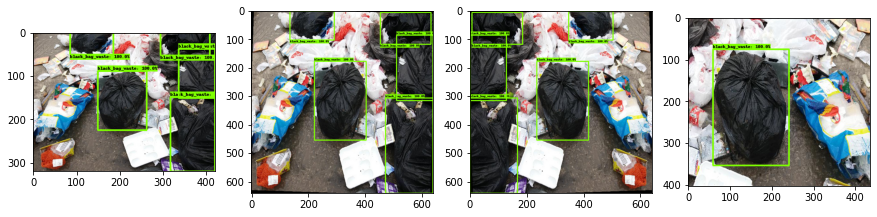

In [31]:
plt.rcParams['figure.figsize'] = [15, 10]

idx = 0

plt.subplot(1, 4, 1)
plot_detections(
      cv2.resize(x_train_np[idx], dsize=(421, 320), interpolation=cv2.INTER_CUBIC).astype('int'),
      y_train_boxes[idx],
      y_train_classes[idx],
      np.ones(shape=[y_train_boxes[idx].shape[0]], dtype=np.float16),
      category_index)

# alpha = -math.pi/4

rotated_image, rotated_box = random_rotate(x_train_np[idx], y_train_boxes[idx], 1)

plt.subplot(1, 4, 2)
plot_detections(
      rotated_image,
      rotated_box,
      y_train_classes[idx],
      np.ones(shape=[y_train_boxes[idx].shape[0]], dtype=np.float16),
      category_index)

flipped_image, flipped_box = random_horizontal_flip(rotated_image, rotated_box, 1)

plt.subplot(1, 4, 3)

plot_detections(
      flipped_image,
      flipped_box,
      y_train_classes[idx],
      np.ones(shape=[y_train_boxes[idx].shape[0]], dtype=np.float16),
      category_index)

cropped_image, cropped_boxes, cropped_classes = random_crop(flipped_image, flipped_box, y_train_classes[idx], 1)

plt.subplot(1, 4, 4)
plot_detections(
      cropped_image,
      cropped_boxes,
      cropped_classes,
      np.ones(shape=[y_train_boxes[idx].shape[0]], dtype=np.float16),
      category_index)

# Training Block

This block contains: 
* Training Top
* Training Middle
* Training Whole
* Save trained Model


## Save untuned


In [32]:
untuned_checkpoint = ckpt.save(checkpoint_path+'-untuned') 

In [33]:
# Optional - load
ckpt = restore_weights(untuned_checkpoint, restore_all = True)

restoring weights from ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-untuned-52
Weights restored!


## Top


### Hyperparameters


In [34]:
# SELECT THE TOP LAYERS, and set up the training
tf.keras.backend.clear_session()

# Hyper parameters
epochs = 100
batch_size = 5
num_batches = (len(x_train_np) // batch_size)

# Define Optimizer
optimizer = tf.keras.optimizers.Adam()

# Select variables in top layers to fine-tune.
to_fine_tune = get_variables(['WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
                              'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead'])

# Get step function
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

# Run on CV:
test_loss, map = test_evaluate()
print(f'loss: {test_loss :.6}, map: {map :.6}')

# Untuned - 1.45610507329305

loss: 1.47491, map: 0.0


### Train

In [35]:
train(epochs, batch_size, train_step_fn, flip_prob = 0.2, rotate_prob = 0.2, hue_prob = 0.2, crop_prob = 0.2)

Started fine-tuning!
Initial cv_loss: 1.474907, cv_map: 0.000000



epoch 1 of 100, loss= 1.38791, cv_loss = 1.20389, cv_map = 0.0



epoch 2 of 100, loss= 1.10179, cv_loss = 0.919629, cv_map = 0.0882841



epoch 3 of 100, loss= 1.03087, cv_loss = 0.893463, cv_map = 0.114366



epoch 4 of 100, loss= 0.941882, cv_loss = 0.86251, cv_map = 0.132767



epoch 5 of 100, loss= 0.933306, cv_loss = 0.817639, cv_map = 0.139052



epoch 6 of 100, loss= 0.900643, cv_loss = 0.818542, cv_map = 0.136909



epoch 7 of 100, loss= 0.885255, cv_loss = 0.795054, cv_map = 0.134632



epoch 8 of 100, loss= 0.888905, cv_loss = 0.798356, cv_map = 0.141707



epoch 9 of 100, loss= 0.873886, cv_loss = 0.795303, cv_map = 0.143427



epoch 10 of 100, loss= 0.893968, cv_loss = 0.78541, cv_map = 0.148835



epoch 11 of 100, loss= 0.886068, cv_loss = 0.772443, cv_map = 0.141758



epoch 12 of 100, loss= 0.866603, cv_loss = 0.779953, cv_map = 0.147181



epoch 13 of 100, loss= 0.867619, cv_loss = 0.771723, cv_map = 0.14585



epoch 14 of 100, loss= 0.875798, cv_loss = 0.770757, cv_map = 0.147898



epoch 15 of 100, loss= 0.84363, cv_loss = 0.775001, cv_map = 0.143357



epoch 16 of 100, loss= 0.856676, cv_loss = 0.767919, cv_map = 0.140803



epoch 17 of 100, loss= 0.865118, cv_loss = 0.764979, cv_map = 0.133148



epoch 18 of 100, loss= 0.843839, cv_loss = 0.761328, cv_map = 0.142195



epoch 19 of 100, loss= 0.852533, cv_loss = 0.759262, cv_map = 0.151757



epoch 20 of 100, loss= 0.84872, cv_loss = 0.760693, cv_map = 0.147806



epoch 21 of 100, loss= 0.854294, cv_loss = 0.764294, cv_map = 0.141897



epoch 22 of 100, loss= 0.855695, cv_loss = 0.76159, cv_map = 0.1476



epoch 23 of 100, loss= 0.8288, cv_loss = 0.768196, cv_map = 0.139481



epoch 24 of 100, loss= 0.836356, cv_loss = 0.765753, cv_map = 0.147849



epoch 25 of 100, loss= 0.844054, cv_loss = 0.771089, cv_map = 0.149749



epoch 26 of 100, loss= 0.835607, cv_loss = 0.756791, cv_map = 0.150238



epoch 27 of 100, loss= 0.838358, cv_loss = 0.754126, cv_map = 0.153241



epoch 28 of 100, loss= 0.834163, cv_loss = 0.763475, cv_map = 0.144637



epoch 29 of 100, loss= 0.835421, cv_loss = 0.759774, cv_map = 0.147352



epoch 30 of 100, loss= 0.826491, cv_loss = 0.776145, cv_map = 0.149316



epoch 31 of 100, loss= 0.82771, cv_loss = 0.758456, cv_map = 0.14713



epoch 32 of 100, loss= 0.825946, cv_loss = 0.761353, cv_map = 0.152269



epoch 33 of 100, loss= 0.826162, cv_loss = 0.761486, cv_map = 0.154092



epoch 34 of 100, loss= 0.834436, cv_loss = 0.763475, cv_map = 0.147727



epoch 35 of 100, loss= 0.820323, cv_loss = 0.750677, cv_map = 0.135734



epoch 36 of 100, loss= 0.842702, cv_loss = 0.757937, cv_map = 0.156387



epoch 37 of 100, loss= 0.810966, cv_loss = 0.770295, cv_map = 0.145133



epoch 38 of 100, loss= 0.846477, cv_loss = 0.74913, cv_map = 0.144438



epoch 39 of 100, loss= 0.801566, cv_loss = 0.762004, cv_map = 0.148953



epoch 40 of 100, loss= 0.830025, cv_loss = 0.763143, cv_map = 0.151898



epoch 41 of 100, loss= 0.82358, cv_loss = 0.753105, cv_map = 0.15452



epoch 42 of 100, loss= 0.826044, cv_loss = 0.749371, cv_map = 0.151562



epoch 43 of 100, loss= 0.84343, cv_loss = 0.758934, cv_map = 0.14566



epoch 44 of 100, loss= 0.797167, cv_loss = 0.758337, cv_map = 0.145978



epoch 45 of 100, loss= 0.829939, cv_loss = 0.756513, cv_map = 0.149621



epoch 46 of 100, loss= 0.812607, cv_loss = 0.764001, cv_map = 0.143481



epoch 47 of 100, loss= 0.822251, cv_loss = 0.757211, cv_map = 0.136207



epoch 48 of 100, loss= 0.8232, cv_loss = 0.750059, cv_map = 0.148062



epoch 49 of 100, loss= 0.822515, cv_loss = 0.756365, cv_map = 0.164881



epoch 50 of 100, loss= 0.828013, cv_loss = 0.747894, cv_map = 0.159832



epoch 51 of 100, loss= 0.812853, cv_loss = 0.763509, cv_map = 0.156203



epoch 52 of 100, loss= 0.808237, cv_loss = 0.763214, cv_map = 0.147672



epoch 53 of 100, loss= 0.794684, cv_loss = 0.762036, cv_map = 0.156266



epoch 54 of 100, loss= 0.814035, cv_loss = 0.755548, cv_map = 0.166818



epoch 55 of 100, loss= 0.802374, cv_loss = 0.764706, cv_map = 0.152625



epoch 56 of 100, loss= 0.800556, cv_loss = 0.748368, cv_map = 0.15457



epoch 57 of 100, loss= 0.822972, cv_loss = 0.747099, cv_map = 0.164167



epoch 58 of 100, loss= 0.808246, cv_loss = 0.765684, cv_map = 0.151455



epoch 59 of 100, loss= 0.809355, cv_loss = 0.763044, cv_map = 0.155949



epoch 60 of 100, loss= 0.788262, cv_loss = 0.76563, cv_map = 0.157787



epoch 61 of 100, loss= 0.803043, cv_loss = 0.757039, cv_map = 0.156928



epoch 62 of 100, loss= 0.823262, cv_loss = 0.759568, cv_map = 0.167382



epoch 63 of 100, loss= 0.807606, cv_loss = 0.752763, cv_map = 0.158859



epoch 64 of 100, loss= 0.80601, cv_loss = 0.771694, cv_map = 0.151502



epoch 65 of 100, loss= 0.803414, cv_loss = 0.762999, cv_map = 0.169769



epoch 66 of 100, loss= 0.816442, cv_loss = 0.783891, cv_map = 0.162837



epoch 67 of 100, loss= 0.806113, cv_loss = 0.748578, cv_map = 0.161987



epoch 68 of 100, loss= 0.819917, cv_loss = 0.749812, cv_map = 0.165467



epoch 69 of 100, loss= 0.812566, cv_loss = 0.744363, cv_map = 0.158232



epoch 70 of 100, loss= 0.833568, cv_loss = 0.75368, cv_map = 0.164735



epoch 71 of 100, loss= 0.804286, cv_loss = 0.744536, cv_map = 0.162276



epoch 72 of 100, loss= 0.809799, cv_loss = 0.755406, cv_map = 0.167196



epoch 73 of 100, loss= 0.808994, cv_loss = 0.763897, cv_map = 0.173494



epoch 74 of 100, loss= 0.813591, cv_loss = 0.773244, cv_map = 0.15729



epoch 75 of 100, loss= 0.801419, cv_loss = 0.783729, cv_map = 0.165054



epoch 76 of 100, loss= 0.818836, cv_loss = 0.773196, cv_map = 0.176601



epoch 77 of 100, loss= 0.833947, cv_loss = 0.825032, cv_map = 0.170958



epoch 78 of 100, loss= 0.808119, cv_loss = 0.754911, cv_map = 0.166395



epoch 79 of 100, loss= 0.818235, cv_loss = 0.771137, cv_map = 0.15218



epoch 80 of 100, loss= 0.801021, cv_loss = 0.751122, cv_map = 0.163334



epoch 81 of 100, loss= 0.815392, cv_loss = 0.748862, cv_map = 0.159199



epoch 82 of 100, loss= 0.81841, cv_loss = 0.749005, cv_map = 0.163451



epoch 83 of 100, loss= 0.815432, cv_loss = 0.786618, cv_map = 0.165248



epoch 84 of 100, loss= 0.807576, cv_loss = 0.760098, cv_map = 0.16493



epoch 85 of 100, loss= 0.80294, cv_loss = 0.749877, cv_map = 0.164882



epoch 86 of 100, loss= 0.789561, cv_loss = 0.755639, cv_map = 0.176996



epoch 87 of 100, loss= 0.806894, cv_loss = 0.756825, cv_map = 0.172323



epoch 88 of 100, loss= 0.799721, cv_loss = 0.744115, cv_map = 0.168742



epoch 89 of 100, loss= 0.800193, cv_loss = 0.752436, cv_map = 0.177359



epoch 90 of 100, loss= 0.800274, cv_loss = 0.745173, cv_map = 0.163539



epoch 91 of 100, loss= 0.80426, cv_loss = 0.750661, cv_map = 0.17754



epoch 92 of 100, loss= 0.80246, cv_loss = 0.754132, cv_map = 0.176625



epoch 93 of 100, loss= 0.823831, cv_loss = 0.781681, cv_map = 0.176103



epoch 94 of 100, loss= 0.793057, cv_loss = 0.741949, cv_map = 0.171881



epoch 95 of 100, loss= 0.802072, cv_loss = 0.745366, cv_map = 0.171349



epoch 96 of 100, loss= 0.807735, cv_loss = 0.746016, cv_map = 0.179854



epoch 97 of 100, loss= 0.819399, cv_loss = 0.766954, cv_map = 0.172486



epoch 98 of 100, loss= 0.793632, cv_loss = 0.752461, cv_map = 0.174169



epoch 99 of 100, loss= 0.794016, cv_loss = 0.751112, cv_map = 0.171156



epoch 100 of 100, loss= 0.790372, cv_loss = 0.747748, cv_map = 0.175336
final cv_loss: 0.747748, cv_map: 0.175336
Done fine-tuning!


### Save

In [36]:
top_trained_checkpoint = ckpt.save(checkpoint_path+'-top')
# top_trained_checkpoint = checkpoint_path + '-top_trained-55'
print(top_trained_checkpoint)

ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-top-53


## Mid

In [37]:
# Restore weights
restore_weights(top_trained_checkpoint, restore_all=True)

restoring weights from ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-top-53
Weights restored!


### Hyperparameters

In [44]:
# Select box predictor variables to train

# Hyperparameters
epochs = 20
batch_size = 5
num_batches = (len(x_train_np) // batch_size)

optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

# Select variables in top layers to fine-tune.
to_fine_tune = get_variables(['WeightSharedConvolutionalBoxPredictor'])

# Get step function
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

# Run on CV:
test_loss, map = test_evaluate()
print(f'loss: {test_loss :.6}, map: {map :.6}')

# top-trained:0.8682906

# 50

loss: 0.663285, map: 0.379793


### Train

In [45]:
train(epochs, batch_size, train_step_fn, flip_prob = 0.2, rotate_prob = 0.2, hue_prob = 0.2, crop_prob = 0.2)

Started fine-tuning!
Initial cv_loss: 0.663285, cv_map: 0.379793



epoch 1 of 20, loss= 0.627736, cv_loss = 0.679172, cv_map = 0.3461



epoch 2 of 20, loss= 0.604824, cv_loss = 0.67289, cv_map = 0.358807



epoch 3 of 20, loss= 0.612153, cv_loss = 0.664518, cv_map = 0.363146



epoch 4 of 20, loss= 0.570712, cv_loss = 0.668202, cv_map = 0.374266



epoch 5 of 20, loss= 0.60575, cv_loss = 0.66717, cv_map = 0.370135



epoch 6 of 20, loss= 0.58422, cv_loss = 0.670917, cv_map = 0.361945



epoch 7 of 20, loss= 0.592519, cv_loss = 0.675387, cv_map = 0.348591



epoch 8 of 20, loss= 0.596095, cv_loss = 0.685159, cv_map = 0.356063



epoch 9 of 20, loss= 0.610131, cv_loss = 0.661127, cv_map = 0.361292



epoch 10 of 20, loss= 0.616229, cv_loss = 0.698673, cv_map = 0.330194



epoch 11 of 20, loss= 0.605094, cv_loss = 0.670283, cv_map = 0.32922



epoch 12 of 20, loss= 0.589443, cv_loss = 0.670943, cv_map = 0.349296



epoch 13 of 20, loss= 0.597373, cv_loss = 0.67265, cv_map = 0.332144



epoch 14 of 20, loss= 0.602346, cv_loss = 0.671657, cv_map = 0.35787



epoch 15 of 20, loss= 0.587961, cv_loss = 0.666698, cv_map = 0.344641



epoch 16 of 20, loss= 0.569055, cv_loss = 0.67273, cv_map = 0.369999



epoch 17 of 20, loss= 0.589636, cv_loss = 0.664977, cv_map = 0.350111



epoch 18 of 20, loss= 0.590945, cv_loss = 0.663843, cv_map = 0.37031



epoch 19 of 20, loss= 0.577921, cv_loss = 0.666318, cv_map = 0.358464



epoch 20 of 20, loss= 0.584206, cv_loss = 0.674211, cv_map = 0.35194
final cv_loss: 0.674211, cv_map: 0.35194
Done fine-tuning!


### Save

In [43]:
big_top_path = ckpt.save(checkpoint_path+'-boxPredictor')

## All

In [46]:
restore_weights(big_top_path, restore_all=True)

restoring weights from ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-boxPredictor-55
Weights restored!


### Hyperparameters

In [47]:
# Select all variables to train
tf.keras.backend.clear_session()
# Hyperparameters
epochs = 10
batch_size = 5
num_batches = (len(x_train_np) // batch_size)

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-6)

# Select variables in top layers to fine-tune.
# to_fine_tune = get_variables(['WeightSharedConvolutionalBoxPredictor'])
to_fine_tune = detection_model.trainable_variables

# Get step function
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

# loss = train_step_fn(train_image_tensors, gt_box_tensors, gt_classes_one_hot_tensors, backprop=False)
cv_loss = test_evaluate()

# print(loss.numpy())
print(cv_loss)

# big-top-trained: 0.8113712

(0.6632853746414185, 0.3797927553419853)


### Train

In [50]:
train(epochs, batch_size, train_step_fn, flip_prob = 0.2, rotate_prob = 0.2, hue_prob = 0.2, crop_prob = 0.2)

Started fine-tuning!
Initial cv_loss: 0.652813, cv_map: 0.368289



epoch 1 of 10, loss= 0.562485, cv_loss = 0.653423, cv_map = 0.357641



epoch 2 of 10, loss= 0.561495, cv_loss = 0.653816, cv_map = 0.362727



epoch 3 of 10, loss= 0.580228, cv_loss = 0.648215, cv_map = 0.376644



epoch 4 of 10, loss= 0.564077, cv_loss = 0.651003, cv_map = 0.370436



epoch 5 of 10, loss= 0.550142, cv_loss = 0.647156, cv_map = 0.392886



epoch 6 of 10, loss= 0.559546, cv_loss = 0.647455, cv_map = 0.395757



epoch 7 of 10, loss= 0.557163, cv_loss = 0.648399, cv_map = 0.396345



epoch 8 of 10, loss= 0.554688, cv_loss = 0.647425, cv_map = 0.405647



epoch 9 of 10, loss= 0.538238, cv_loss = 0.645617, cv_map = 0.412057



epoch 10 of 10, loss= 0.544052, cv_loss = 0.643429, cv_map = 0.37751
final cv_loss: 0.643429, cv_map: 0.37751
Done fine-tuning!


### Save

In [51]:
entire_model_path = ckpt.save(checkpoint_path+'-all-trained')

In [52]:
restore_weights(entire_model_path, restore_all=True)

cv_loss = test_evaluate()

print(cv_loss)

restoring weights from ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-all-trained-57
Weights restored!
(0.6434293389320374, 0.3775104907648815)


## Optional: export ckpt

In [59]:
# Create export folder
model_to_export = ckpt.save('to_export/ckpt')

In [60]:
# Create zip file
%%bash
cd 'to_export'
ls
zip -r binbag_only_mobilenet.zip . -x ".*" -x "__MACOSX"
# cp 'export/seven_classes.zip' '/content/drive/My Drive/ML'

checkpoint
ckpt-59.data-00000-of-00001
ckpt-59.index
  adding: checkpoint (deflated 38%)
  adding: ckpt-59.index (deflated 80%)
  adding: ckpt-59.data-00000-of-00001 (deflated 8%)


In [61]:
# Copy to drive
!cp 'to_export/binbag_only_mobilenet.zip' '/content/drive/My Drive/ML/saved_checkpoints'

# Test


## Optional: Load trained ckpt

In [62]:
# !cp '/content/drive/My Drive/ML/checkpoints2.zip' .
!cp '/content/drive/My Drive/ML/saved_checkpoints/binbag_only_mobilenet.zip' .
!unzip -q binbag_only_mobilenet.zip
# Remove the zip file 
!rm binbag_only_mobilenet.zip 

In [64]:
restore_weights('ckpt-59')

test_evaluate()

restoring weights from ckpt-59
Weights restored!


(0.6536591053009033, 0.3605780803088414)

## detect()


In [53]:
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)


In [54]:
plt.figure(figsize=(20,20))
for i in range(12):
  offset = 0
  input_tensor = tf.convert_to_tensor(np.expand_dims(x_test_np[i+offset], axis=0), dtype=tf.float32)
  detection = detect(input_tensor)
  plt.subplot(4, 3, i+1)
  plot_detections(
      cv2.resize(x_test_np[i+offset], dsize=(824, 640), interpolation=cv2.INTER_CUBIC),
      detection['detection_boxes'][0].numpy(),
      detection['detection_classes'][0].numpy().astype(np.uint32)
      + 1,
      detection['detection_scores'][0].numpy(),
      category_index,
      threshold = 0.4)
plt.show()



Output hidden; open in https://colab.research.google.com to view.

# mAP

## Detection vs gt

In [67]:
idx = 0

5


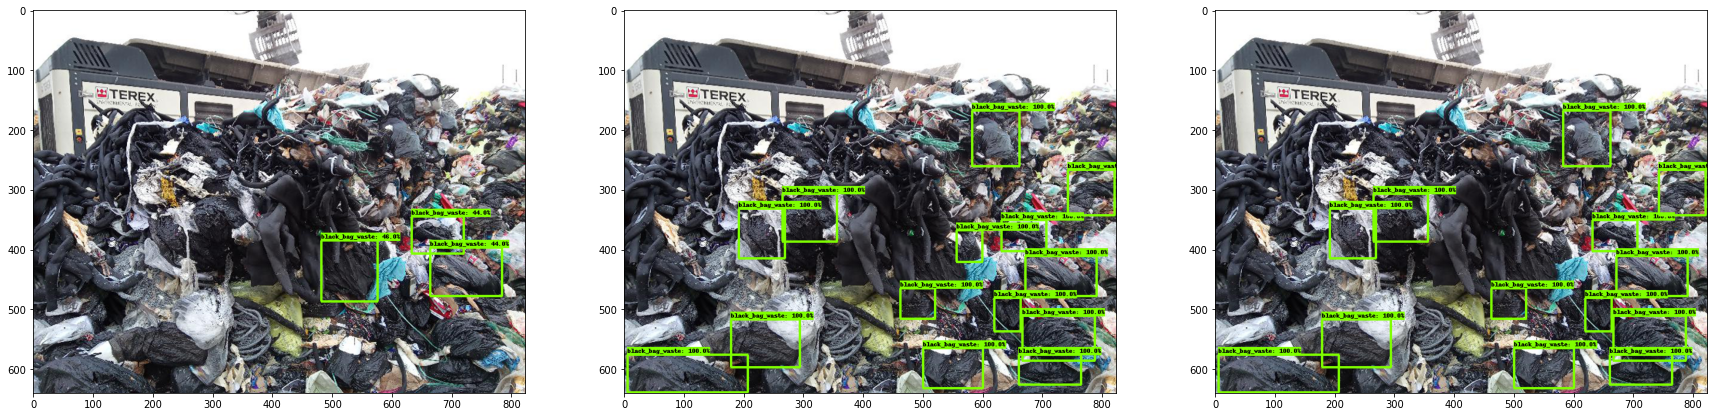

In [73]:
# idx = 3

plt.figure(figsize=(30, 10))
detection = detect(test_image_tensors[idx])

plt.subplot(1, 3, 1)
plot_detections(
      cv2.resize(x_test_np[idx], dsize=(824, 640), interpolation=cv2.INTER_CUBIC),
      detection['detection_boxes'][0].numpy(),
      detection['detection_classes'][0].numpy().astype(np.uint32)
      + 1,
      detection['detection_scores'][0].numpy(),
      category_index,
      threshold = 0.4)

plt.subplot(1, 3, 2)
plot_detections(
      cv2.resize(x_test_np[idx], dsize=(824, 640), interpolation=cv2.INTER_CUBIC),
      y_test_boxes[idx],
      y_test_classes[idx],
      np.ones(shape=[y_test_classes[idx].shape[0]], dtype=np.float16),
      category_index)

plt.subplot(1, 3, 3)
plot_detections(
      cv2.resize(x_test_np[idx], dsize=(824, 640), interpolation=cv2.INTER_CUBIC),
      y_test_boxes_trivial[idx],
      y_test_classes_trivial[idx],
      np.ones(shape=[y_test_classes[idx].shape[0]], dtype=np.float16),
      category_index)

print(idx)
idx += 1

## mAP Block

## mAP - Train

In [55]:
detected_boxes_train = []
detected_classes_train = []
detected_scores_train = []

for i in tqdm(range(len(y_train_classes))):
  detection = detect(train_image_tensors[i])
  detected_score, detected_class, detected_box = filter_from_score(detection['detection_scores'][0].numpy(),
                                                                  detection['detection_classes'][0].numpy()+1,
                                                                  detection['detection_boxes'][0].numpy(),
                                                                  threshold = 0.4)
  detected_boxes_train.append(detected_box)
  detected_classes_train.append(detected_class)
  detected_scores_train.append(detected_score)


In [56]:
p, r, map = calculate_map(detected_boxes_train, 
                          detected_classes_train, 
                          detected_scores_train, 
                          y_train_boxes, 
                          y_train_classes, 
                          num_of_classes = num_classes,
                          iou_threshold = 0.5,
                          suppress_output = False)

print(map)

print(sum(map)/num_classes)

# print('\n Trivial: ')

# p, r, map = calculate_map(detected_boxes, 
#                           detected_classes, 
#                           detected_scores, 
#                           y_train_boxes_trivial, 
#                           y_train_classes_trivial, 
#                           num_of_classes = num_classes,
#                           iou_threshold = 0.5)

# print(map)



black_bag_waste: 480 annotations
264 / 346 correct detections 

[0.5131139865791926]
0.5131139865791926


## mAP - Test

In [63]:
detected_boxes = []
detected_classes = []
detected_scores = []

for i in tqdm(range(len(x_test_np))):
  detection = detect(test_image_tensors[i])
  detected_score, detected_class, detected_box = filter_from_score(detection['detection_scores'][0].numpy(),
                                                                  detection['detection_classes'][0].numpy()+1,
                                                                  detection['detection_boxes'][0].numpy(),
                                                                  threshold = 0.4)
  detected_boxes.append(detected_box)
  detected_classes.append(detected_class)
  detected_scores.append(detected_score)

In [64]:
p, r, map = calculate_map(detected_boxes, 
                          detected_classes, 
                          detected_scores, 
                          y_test_boxes, 
                          y_test_classes, 
                          num_of_classes = num_classes,
                          iou_threshold = 0.4, 
                          suppress_output = False)

print(map)
print(f'mAP: {sum(map)/num_classes}')

print('----------------------------------------')
print('\nExcluding difficult annotations: \n')
p, r, map = calculate_map(detected_boxes, 
                          detected_classes, 
                          detected_scores, 
                          y_test_boxes_trivial, 
                          y_test_classes_trivial, 
                          num_of_classes = num_classes,
                          iou_threshold = 0.4,
                          suppress_output = False)

print(map)
print(f'mAP: {sum(map)/num_classes}')

black_bag_waste: 132 annotations
49 / 69 correct detections 

[0.31623682337109066]
mAP: 0.31623682337109066
----------------------------------------

Excluding difficult annotations: 

black_bag_waste: 98 annotations
45 / 69 correct detections 

[0.38587246499870576]
mAP: 0.38587246499870576


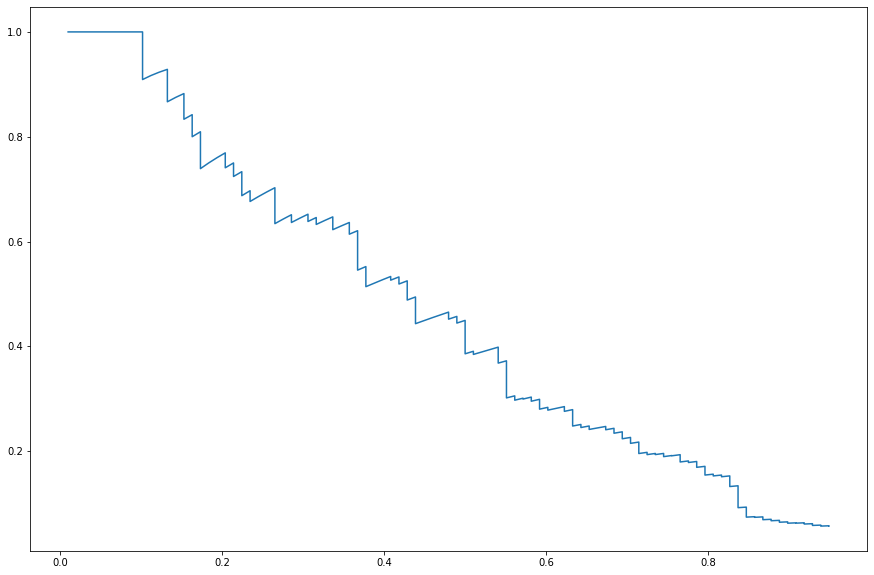

In [62]:
plt.plot(r[0], p[0])